# **Evaluation of the models**

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import json

import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import utils

## **Model performance evaluation**

In [2]:
test_data = pd.read_csv("../../02_data/nn_baseline_test.csv", header=None)
test_data = np.array(test_data)

In [3]:
model = keras.models.load_model("../../04_nn_models/fed_noshare2/")

2023-02-08 12:50:28.727519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 12:50:28.732476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 12:50:28.732656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 12:50:28.733238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
result = model.evaluate(test_data[:,:-1],
                  test_data[:,-1], batch_size=1000)

print("Test loss:\t%.4f"%result)

142/762 [====>.........................] - ETA: 0s - loss: 1.0570

2023-02-05 12:02:35.619363: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


762/762 [==============================] - 1s 1ms/step - loss: 1.0156
Test loss:	1.0156


In [4]:
PARKING_ID_LIST = [i for i in range(1059, 1186+1)]
MIN_T = 14400
MAX_T = 50460
MEAN = 0.59
STD = 0.35302

MEAS_ROOT = "../../dockeroutput/"

In [5]:
nominals = pd.read_csv(MEAS_ROOT+"day_59/occupancies.csv")

MOST_PATH = "../../build_inputs//MoSTScenario/scenario/most.sumocfg"
PARKING_AREA_DEFINITIONS = "../../build_inputs/MoSTScenario/scenario/in/add/most.parking.add.xml"

parking_df = pd.read_xml(PARKING_AREA_DEFINITIONS)
parking_df = parking_df[parking_df["roadsideCapacity"]>0]
parking_df = parking_df.set_index(["id"])

perc_ = []
for i,r in nominals.iterrows():
    perc_.append(r.counts/parking_df.loc[r.ids]["roadsideCapacity"])
nominals["percentage"] = perc_

In [17]:
PARKING_ID = 1150

In [18]:
id_list = PARKING_ID_LIST

test_t = np.arange(14400, 50400, 60)
test_t = utils.normalize(test_t, MIN_T, MAX_T)

id_encoding = utils.one_hot_encoder([PARKING_ID]*len(test_t), id_list)
#print(id_encoding.shape)

test_d = np.hstack([id_encoding, test_t.reshape(len(test_t), 1)])
#print(test_d.shape)

output = model.predict(test_d)
output = utils.de_standardize(output, MEAN, STD)

19/19 [==============================] - 0s 779us/step


In [19]:
lot=PARKING_ID

oracle = pd.read_csv("../../02_data/oracle.csv")
p_lot = oracle[oracle["ids"] == lot]
p_lot_occup_mean = p_lot.groupby("timestamp")["percentage"].mean()
p_lot_occup_std = p_lot.groupby("timestamp")["percentage"].std()

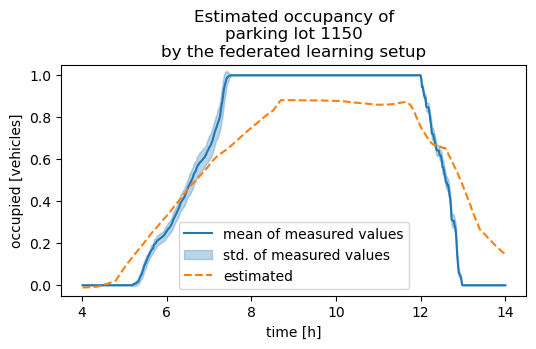

In [20]:
plt.figure(figsize=[6,3])
p_lot = oracle[oracle["ids"] == PARKING_ID]
p_lot_occup_mean = p_lot.groupby("timestamp")["percentage"].mean()
p_lot_occup_std = p_lot.groupby("timestamp")["percentage"].std()
plt.plot(p_lot_occup_mean.index/(60*60), p_lot_occup_mean, label="mean of measured values")
plt.fill_between(p_lot_occup_mean.index/(60*60), p_lot_occup_mean-p_lot_occup_std,
                 p_lot_occup_mean+p_lot_occup_std, alpha=0.3, color="tab:blue",
                 label="std. of measured values")
plt.plot(p_lot_occup_mean.index/(60*60), output, "--", label="estimated")
plt.xlabel("time [h]")
plt.ylabel("occupied [vehicles]")
plt.legend()
plt.title("Estimated occupancy of\nparking lot %d\nby the federated learning setup"%PARKING_ID)
plt.ylim(-.05, 1.05)
plt.show()

## **Evaluation inference results**

In [10]:
with open("../../02_data/fed_accuracies2.json", "r") as f:
    fed_accuracies = json.load(f)

In [11]:
pos_means, pos_stds = [], []
pos_max, pos_min = [], []
for i in range(55):
    pos_means.append(np.mean(fed_accuracies["position_accuracies"][i]))
    pos_stds.append(np.std(fed_accuracies["position_accuracies"][i]))
    pos_max.append(np.max(fed_accuracies["position_accuracies"][i]))
    pos_min.append(np.min(fed_accuracies["position_accuracies"][i]))
pos_means = np.array(pos_means)
pos_stds = np.array(pos_stds)

In [32]:
#from https://hai-dang.medium.com/solve-and-implement-linear-regression-126d7ce76597:
class LinearRegression():
    
    def pinv(x: np.ndarray, singular_threshold: float = 1e-10):
        """
        Pseudo inverse.\n
        Params:
            x: matrix to inverse
            singular_threshold: threshold to remove singularvalues
        """
        u, s, vt = np.linalg.svd(x, full_matrices=True)
        n_remaining_singularvalues = sum(s > singular_threshold)
        if not n_remaining_singularvalues:
            raise ArithmeticError("Can't inverse matrix,"
                                  + " all singularvalues are lower than singular_threshold.")
        s = s[:n_remaining_singularvalues]
        ut = u[:,:n_remaining_singularvalues].T
        v = vt[:n_remaining_singularvalues,:].T
        # take the inverse of singularvalues to compute the inverse matrix
        s_i = 1 / s * np.identity(n_remaining_singularvalues)
        return v @ s_i @ ut

    def __init__(self):
        self._beta = None

    def train(self, X: np.ndarray, y: np.ndarray):
        # account for the bias
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        # use Moore-Penrose inverse to make sure that matrix always has inverse
        self._beta = LinearRegression.pinv(X.T @ X) @ X.T @ y

    def predict(self, X: np.ndarray):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        return np.dot(X, self._beta)

In [57]:
lr = LinearRegression()
X = np.arange(0, 55, 1)
lr.train(X.reshape(len(X),1), pos_means.reshape(len(pos_means), 1))
estim = lr.predict(X.reshape(len(X),1))

Text(0.5, 0, 'day')

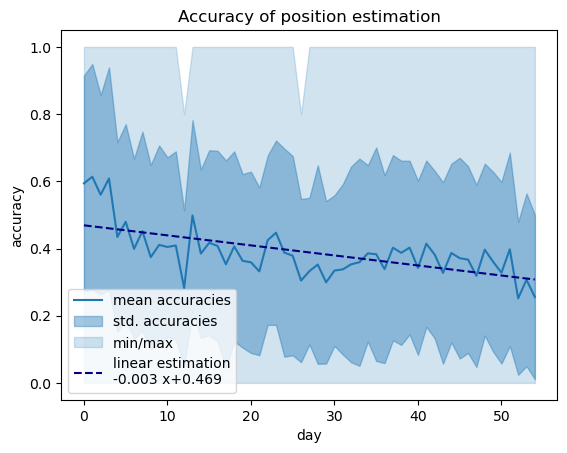

In [60]:
plt.plot(pos_means, color="tab:blue", label="mean accuracies")
plt.fill_between(x=X,
                 y1=pos_means-pos_stds, y2=pos_means+pos_stds, color="tab:blue", label="std. accuracies",
                 alpha=0.4)
plt.fill_between(x=X,
                 y1=pos_min,
                 y2=pos_max,
                 alpha=0.2, color="tab:blue", label="min/max")
plt.plot(estim.reshape(len(X)), "--", color="navy",
         label="linear estimation\n%.3f x+%.3f"%(lr._beta[0], lr._beta[1]))
plt.legend(loc=3)
plt.title("Accuracy of position estimation")
plt.ylabel("accuracy")
plt.xlabel("day")
#plt.plot(pos_min, "--", color="k", label="min")

In [61]:
t_means, t_stds = [], []
t_max, t_min = [], []
for i in range(55):
    t_means.append(np.mean(fed_accuracies["time_accuracies"][i])/3600)
    t_stds.append(np.std(fed_accuracies["time_accuracies"][i])/3600)
    t_max.append(np.max(fed_accuracies["time_accuracies"][i])/3600)
    t_min.append(np.min(fed_accuracies["time_accuracies"][i])/3600)
t_means = np.array(t_means)
t_stds = np.array(t_stds)

In [62]:
lr = LinearRegression()
lr.train(X.reshape(len(X),1), t_means.reshape(len(pos_means), 1))
estim = lr.predict(X.reshape(len(X),1))

Text(0.5, 0, 'day')

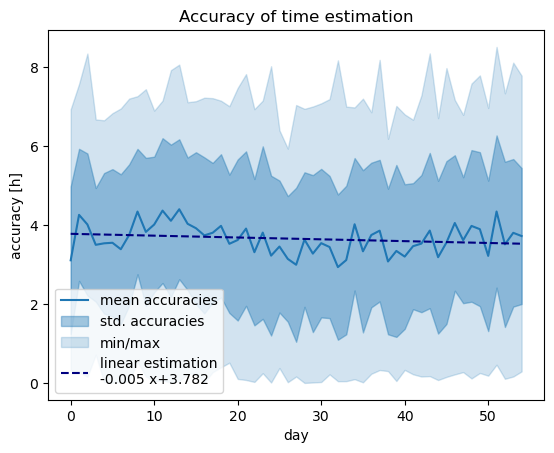

In [65]:
plt.plot(t_means, color="tab:blue", label="mean accuracies")
plt.fill_between(x=X,
                 y1=t_means-t_stds, y2=t_means+t_stds, label="std. accuracies",
                 alpha=0.4, color="tab:blue")
plt.fill_between(x=X,
                 y1=t_min,
                 y2=t_max,
                 alpha=0.2, color="tab:blue", label="min/max")
plt.plot(estim.reshape(len(X)), "--", color="navy",
         label="linear estimation\n%.3f x+%.3f"%(lr._beta[0], lr._beta[1]))
plt.legend(loc=3)
plt.title("Accuracy of time estimation")
plt.ylabel("accuracy [h]")
plt.xlabel("day")